In [23]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Environment setup
RMOOD_HOME = os.getenv("RMOOD_HOME", "/Users/dongyoonhahm/RISE/rmood/reward-modeling")

In [24]:
def visualize_pca_with_rewards(reward_model_name, prompt_idx):
    """
    특정 prompt에 대한 512개의 representation을 PCA로 2D 축소하고,
    reward 값으로 colormap하여 시각화
    
    Args:
        reward_model_name (str): Reward model name (e.g., "Hahmdong/RMOOD-qwen3-4b-alpacafarm-rm")
        prompt_idx (int): Prompt index (e.g., 0, 1, 2, ...)
    """
    # Clean model name for file path
    reward_model_name_clean = reward_model_name.replace("/", "_")
    
    # Construct file paths
    representation_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/representation_{prompt_idx}.npy"
    reward_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/reward_{prompt_idx}.json"
    
    # Check if files exist
    if not os.path.exists(representation_path):
        raise FileNotFoundError(f"Representation file not found: {representation_path}")
    if not os.path.exists(reward_path):
        raise FileNotFoundError(f"Reward file not found: {reward_path}")
    
    # Load representation data
    print(f"Loading representations from: {representation_path}")
    representations = np.load(representation_path)
    print(f"Representation shape: {representations.shape}")
    
    # Load reward data
    print(f"Loading rewards from: {reward_path}")
    with open(reward_path, "r") as f:
        rewards_data = json.load(f)
    rewards = np.array(rewards_data[0])  # Extract the list from the outer array
    print(f"Reward shape: {rewards.shape}")
    
    # Validate data
    assert len(representations) == len(rewards), f"Mismatch: {len(representations)} representations vs {len(rewards)} rewards"
    assert len(representations) == 512, f"Expected 512 samples, got {len(representations)}"
    
    # Apply PCA to reduce to 2D
    print("Applying PCA...")
    pca = PCA(n_components=2)
    representations_2d = pca.fit_transform(representations)
    
    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: PC1={explained_variance[0]:.4f}, PC2={explained_variance[1]:.4f}")
    print(f"Total explained variance: {sum(explained_variance):.4f}")
    
    # Create visualization
    plt.figure(figsize=(10, 7))
    
    # Normalize rewards for colormap
    norm = Normalize(vmin=rewards.min(), vmax=rewards.max())
    colors = cm.viridis(norm(rewards))
    
    # Scatter plot
    scatter = plt.scatter(
        representations_2d[:, 0], 
        representations_2d[:, 1],
        c=rewards,
        cmap='viridis',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Reward', rotation=270, labelpad=20, fontsize=12)
    
    # Labels and title
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)', fontsize=12)
    plt.title(f'PCA Visualization of Responses (Prompt {prompt_idx})\nReward Model: {reward_model_name}', 
              fontsize=14, pad=20)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add statistics text
    stats_text = f'Total samples: {len(rewards)}\n'
    stats_text += f'Reward range: [{rewards.min():.3f}, {rewards.max():.3f}]\n'
    stats_text += f'Mean reward: {rewards.mean():.3f} ± {rewards.std():.3f}'
    plt.text(0.02, 0.98, stats_text, 
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save figure
    output_dir = f"{RMOOD_HOME}/rmood/distribution/visualization/outputs"
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/pca_prompt_{prompt_idx}_{reward_model_name_clean}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return representations_2d, rewards, pca

## Example Usage
아래 셀을 실행하여 특정 prompt에 대한 PCA 시각화를 생성할 수 있습니다.

Loading representations from: /Users/dongyoonhahm/RISE/rmood/reward-modeling/datasets/alpacafarm/distribution/Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm/representation_7.npy
Representation shape: (512, 2560)
Loading rewards from: /Users/dongyoonhahm/RISE/rmood/reward-modeling/datasets/alpacafarm/distribution/Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm/reward_7.json
Reward shape: (512,)
Applying PCA...
Explained variance ratio: PC1=0.3777, PC2=0.0757
Total explained variance: 0.4534

Figure saved to: /Users/dongyoonhahm/RISE/rmood/reward-modeling/rmood/distribution/visualization/outputs/pca_prompt_7_Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm.png


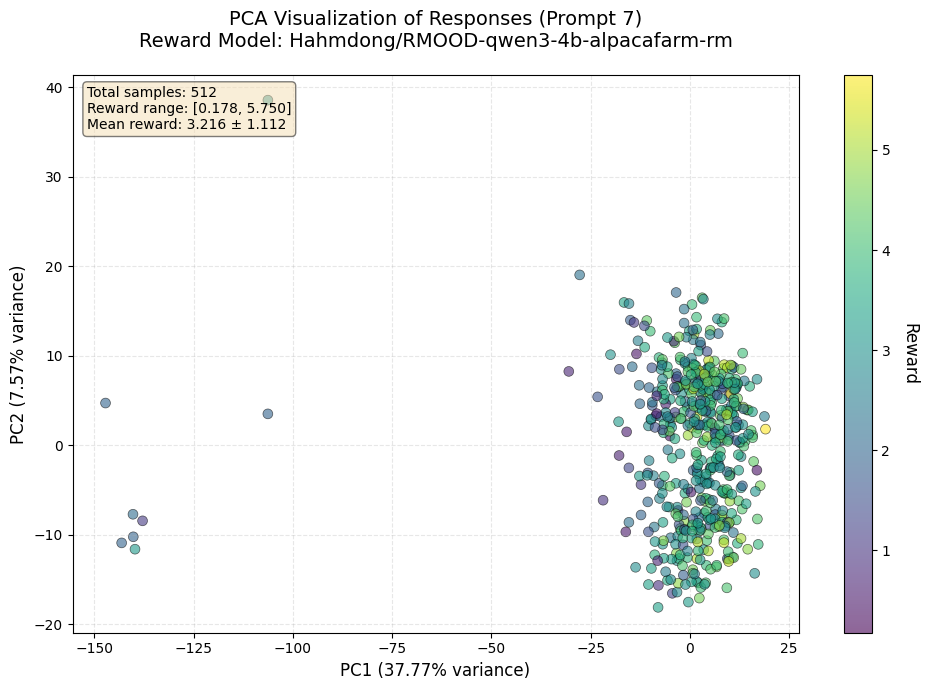

In [30]:
# Example: Visualize prompt index 0 with reward model
reward_model_name = "Hahmdong/RMOOD-qwen3-4b-alpacafarm-rm"
prompt_idx = 7

representations_2d, rewards, pca = visualize_pca_with_rewards(reward_model_name, prompt_idx)

Figure saved to: /Users/dongyoonhahm/RISE/rmood/reward-modeling/rmood/distribution/visualization/outputs/reward_dist_prompt_3_Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm.png


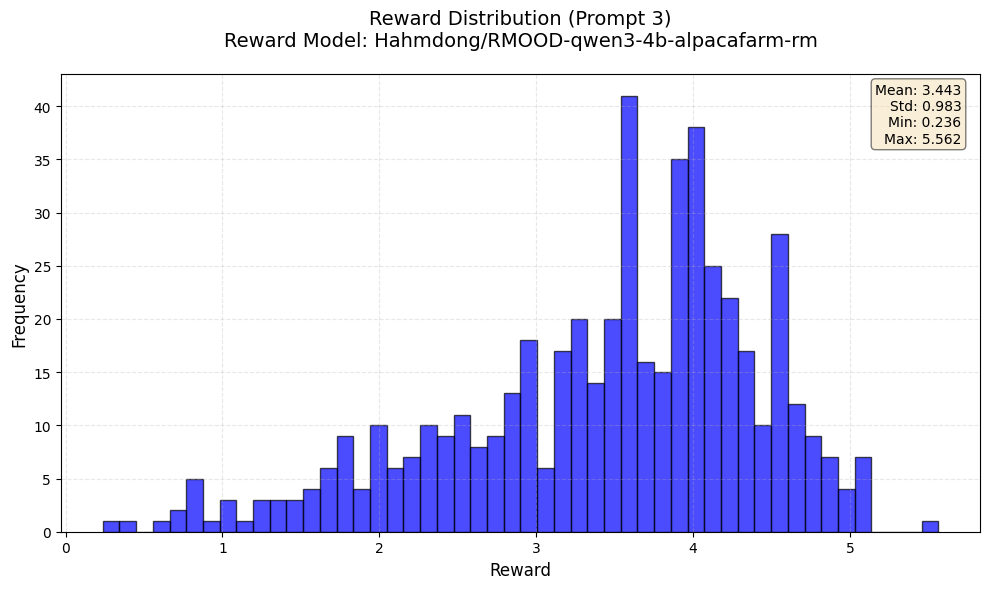

In [26]:
def plot_reward_distribution(reward_model_name, prompt_idx):
    """
    특정 prompt에 대한 reward 분포를 히스토그램으로 시각화
    """
    reward_model_name_clean = reward_model_name.replace("/", "_")
    reward_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/reward_{prompt_idx}.json"
    
    with open(reward_path, "r") as f:
        rewards_data = json.load(f)
    rewards = np.array(rewards_data[0])
    
    plt.figure(figsize=(10, 6))
    plt.hist(rewards, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Reward', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Reward Distribution (Prompt {prompt_idx})\nReward Model: {reward_model_name}', 
              fontsize=14, pad=20)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add statistics
    stats_text = f'Mean: {rewards.mean():.3f}\n'
    stats_text += f'Std: {rewards.std():.3f}\n'
    stats_text += f'Min: {rewards.min():.3f}\n'
    stats_text += f'Max: {rewards.max():.3f}'
    plt.text(0.98, 0.98, stats_text, 
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save figure
    output_dir = f"{RMOOD_HOME}/rmood/distribution/visualization/outputs"
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/reward_dist_prompt_{prompt_idx}_{reward_model_name_clean}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {output_path}")
    
    plt.show()

# Example usage
plot_reward_distribution(reward_model_name, prompt_idx)